<a href="https://colab.research.google.com/github/Mubasshir-Ali/Deep_Learning_Practice/blob/master/6_Color_Images_Dogs_vs_Cats_Softmax_And_Sigmoid_Using_CNNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Dogs vs Cats Image Classification Without Image Augmentation


In [0]:
#@title Import Packages


In [0]:
#from __future__ absolute_import, division, print_function

In [0]:
import tensorflow as tf

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
#@title Data Loading


In [0]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


In [0]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


In [0]:
# We'll now assign variables with the proper file path for the training and validation sets.
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') # directory training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # directory training dog pictures

validation_cats_dir = os.path.join(validation_dir, 'cats') # directory validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # directory validation dog pictures

In [0]:
#@title Understanding Our Data


In [0]:
# Let's look at how many cats and dogs images we have in our training and validation directory
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [0]:
print('Total Training Cat Images:', num_cats_tr)
print('Total Training Dog Images:', num_dogs_tr)

print('Total Validation Cat Images:', num_cats_val)
print('Total Validation Dog Images:', num_dogs_val)

print('---------------------------')

print('Total Training Images:', total_train)
print('Total Validation Images:', total_val)

Total Training Cat Images: 1000
Total Training Dog Images: 1000
Total Validation Cat Images: 500
Total Validation Dog Images: 500
---------------------------
Total Training Images: 2000
Total Validation Images: 1000
Total Training Cat Images: 1000
Total Training Dog Images: 1000
Total Validation Cat Images: 500
Total Validation Dog Images: 500
---------------------------
Total Training Images: 2000
Total Validation Images: 1000


In [0]:
#@title Setting Model Parameters


In [0]:
# Number of training examples to process before updating our models variables
BATCH_SIZE = 100

# Our training data consists of images with width of 150 pixels and height of 150 pixels
IMG_SHAPE = 150

In [0]:
#@title Data Preparation


Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:
1.   Read images from the disk

1.   Decode contents of these images and convert it into proper grid format as per their RGB content 
2.   Convert them into floating point tensors


4.   Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.



In [0]:
# Generator our training data
train_image_generator = ImageDataGenerator(rescale = 1./255)

# Generator our validation data
validation_image_generator = ImageDataGenerator(rescale = 1./255)

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size = BATCH_SIZE, 
                                                           directory = train_dir, 
                                                           shuffle = True, 
                                                           target_size = (IMG_SHAPE, IMG_SHAPE), 
                                                           class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size = BATCH_SIZE, 
                                                           directory = validation_dir, 
                                                           shuffle = True, 
                                                           target_size = (IMG_SHAPE, IMG_SHAPE), 
                                                           class_mode = 'binary')

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
#@title Visualizing Training Images


In [0]:
# We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using matplotlib.
sample_training_images, _ = next(train_data_gen)

In [0]:
# The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels). For right now, we're discarding the labels because we just want to look at the images.
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
      ax.imshow(img)
  
  plt.tight_layout()
  plt.show()

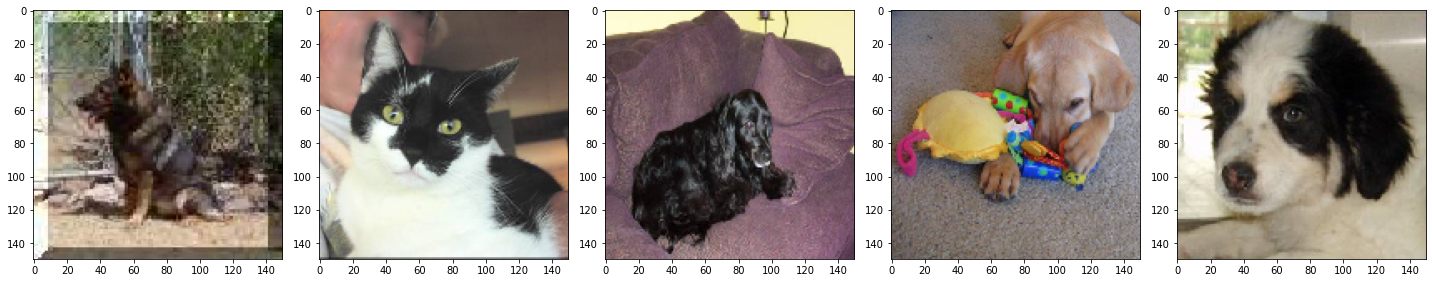

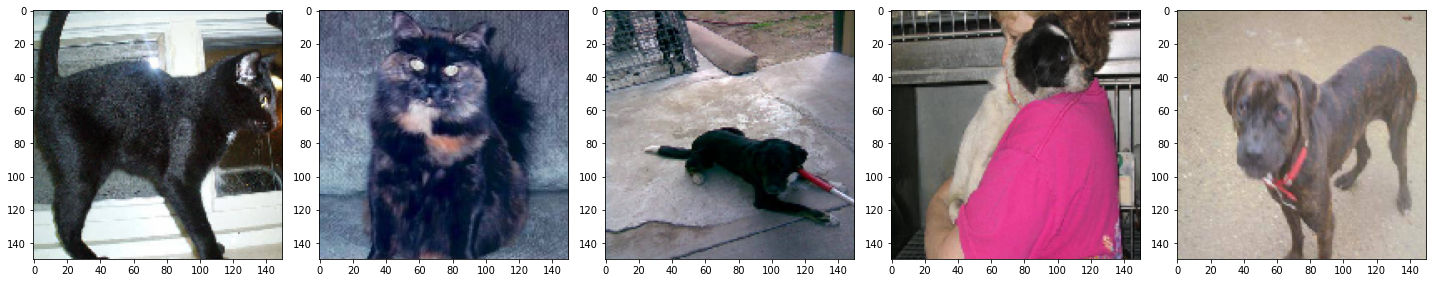

In [0]:
# Plot images 0-4
plotImages(sample_training_images[:5])

In [0]:
#@title Model Creation


In [0]:
#@title Define The Model


The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax.

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (33), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2, 2), 

    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D(2, 2), 

    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2), 

    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'), 
    tf.keras.layers.Dense(2, activation='softmax'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    tf.keras.layers.Dense(2)                                
])

In [0]:
#@title Compile The Model


In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
#@title Model Summary


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      104576    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       1

In [0]:
#@title Train The Model


In [0]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen, 
    steps_per_epoch = int(np.ceil(total_train / float(BATCH_SIZE))), 
    epochs = EPOCHS, 
    validation_data = val_data_gen, 
    validation_steps = int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 9s 452ms/step - loss: 4.2120 - accuracy: 0.5030 - val_loss: 4.2254 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 9s 447ms/step - loss: 4.2294 - accuracy: 0.4990 - val_loss: 4.2011 - val_accuracy: 0.5020
Epoch 3/100
20/20 [==============================] - 9s 446ms/step - loss: 4.2102 - accuracy: 0.5005 - val_loss: 4.3691 - val_accuracy: 0.4800
Epoch 4/100
20/20 [==============================] - 9s 449ms/step - loss: 4.2369 - accuracy: 0.4965 - val_loss: 4.0976 - val_accuracy: 0.5140
Epoch 5/100
20/20 [==============================] - 9s 444ms/step - loss: 4.1633 - accuracy: 0.5055 - val_loss: 4.1741 - val_accuracy: 0.5040
Epoch 6/100
20/20 [==============================] - 9s 445ms/step - loss: 4.2281 - accuracy: 0.4970 - val_loss: 4.2663 - val_accuracy: 0.4920
Epoch 7/100
20/20 [==============================] - 9s 444ms/step - loss: 4.2193 - accuracy: 0.4980 - val_loss: 4.3042 - val_accuracy: 0.4870

In [0]:
#@title Visualizing Results Of The Training


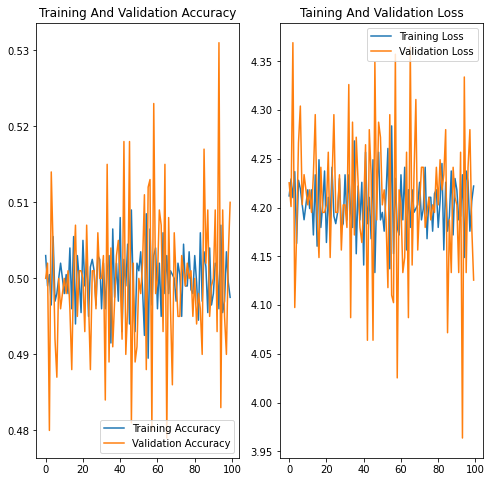

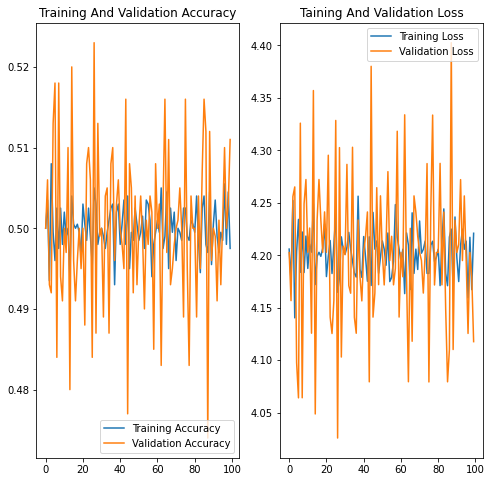

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training And Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Taining And Validation Loss')
plt.savefig('./foo.png')
plt.show()